In [10]:
import intake
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import fsspec
from matplotlib import animation
from IPython.display import HTML, display
import os
import dask.array as da
import time


xr.set_options(display_style='html')
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 
plt.rcParams['figure.figsize'] = 12, 6

In [2]:
from dask.distributed import Client, progress
from dask_kubernetes import KubeCluster
cluster = KubeCluster()
cluster.adapt(minimum=1, maximum=20)
cluster

distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at:   tcp://10.32.29.15:44103
distributed.scheduler - INFO -   dashboard at:                     :8787


In [3]:
client = Client(cluster)
client 

distributed.scheduler - INFO - Receive client connection: Client-fe6f6d52-953b-11ea-81cd-5e608769beaf
distributed.core - INFO - Starting established connection


Client Scheduler: tcp://10.32.29.15:44103 Dashboard: /user/0000-0003-3746-2383/proxy/8787/status,Cluster Workers: 18 Cores: 36 Memory: 207.00 GB


distributed.scheduler - INFO - Register tcp://10.32.63.5:34983
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.63.5:34983
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.63.4:38941
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.63.4:38941
distributed.core - INFO - Starting established connection


### Load data

In [4]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
cat = col.search(experiment_id=['historical'], variable_id='fgco2',
                 grid_label='gn', table_id='Omon')

In [5]:
dset_dict = {}
for name, group in cat.df.groupby('source_id'):
    dsets = [xr.open_zarr(fsspec.get_mapper(zstore), consolidated=True)
             for zstore in group.zstore.values]
    try:
        dsets_aligned = xr.align(*dsets, join='exact')
        dset_dict[name] = xr.concat(dsets, dim='member')
        print(f'concatted {name}')
    except Exception as e:
        print(f'failed to concat {name}')
        print(e)

concatted ACCESS-ESM1-5
concatted BCC-CSM2-MR
concatted BCC-ESM1
concatted CESM2
concatted CESM2-FV2
concatted CESM2-WACCM
concatted CESM2-WACCM-FV2
concatted CNRM-ESM2-1
concatted CanESM5
concatted CanESM5-CanOE
concatted GISS-E2-1-G
concatted GISS-E2-1-G-CC
concatted IPSL-CM6A-LR
concatted MIROC-ES2L
concatted MPI-ESM-1-2-HAM
concatted MPI-ESM1-2-HR
concatted MPI-ESM1-2-LR
concatted MRI-ESM2-0
concatted NorCPM1
concatted NorESM2-LM
concatted NorESM2-MM
failed to concat UKESM1-0-LL
indexes along dimension 'time' are not equal


### Look at one model, CESM2

,Array,Chunk
Bytes,10.71 GB,58.98 MB
Shape,"(11, 1980, 384, 320)","(1, 120, 384, 320)"
Count,1121 Tasks,297 Chunks
Type,float32,numpy.ndarray


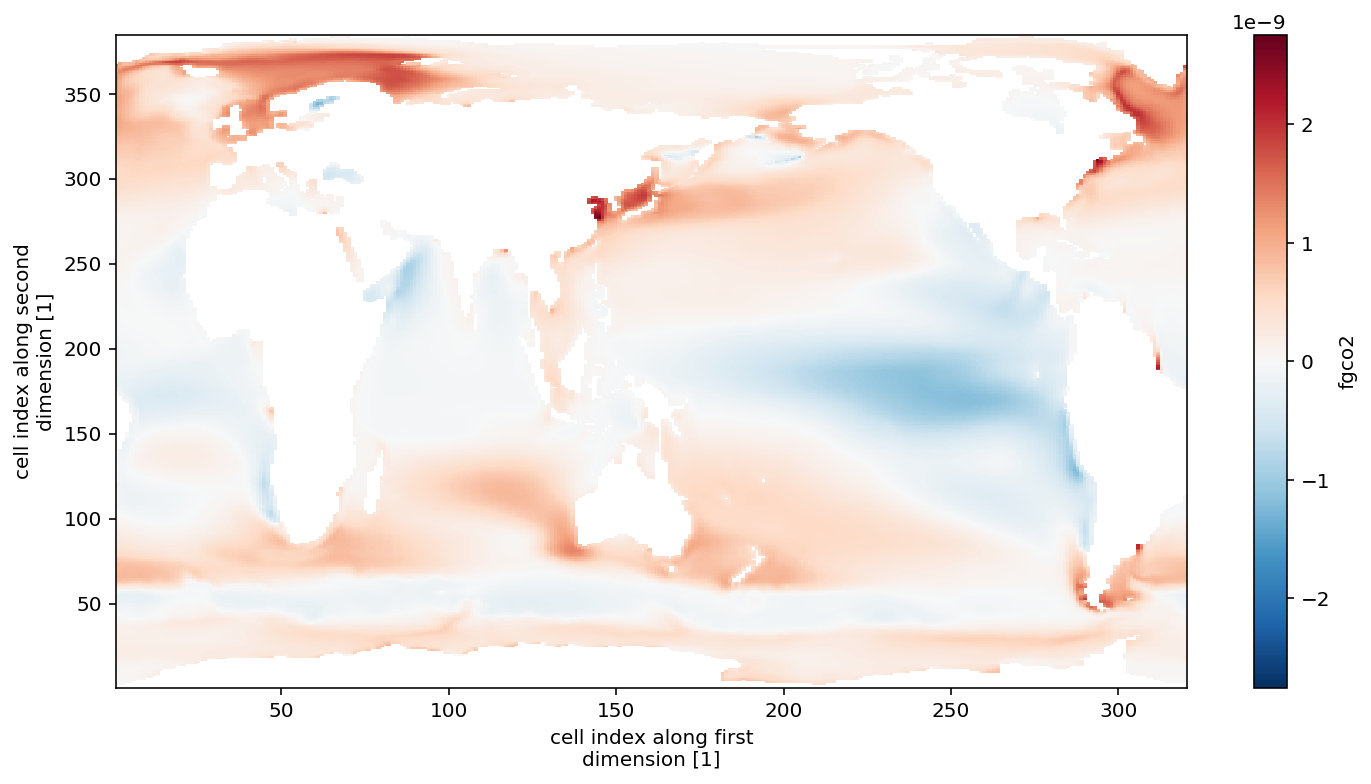

In [11]:
ds = dset_dict['CESM2']
display(ds)
# calculate ensemble mean annual flux in year 2000
fgco2 = ds.fgco2.sel(time='2000', method='nearest').mean(dim=['time', 'member']).load()
fgco2.plot()

### Look at a 10N-10S band in the Pacific

In [12]:
ds_band = (ds.where(ds.lat<10, drop=True)
        .where(ds.lat>-10, drop=True)
        .where(ds.lon>110, drop=True)
        .where(ds.lon<290, drop=True))
ds_band = ds_band.fgco2

In [13]:
# resampled every year
da_yearly = ds_band.resample(time='1Y').mean()
da_yearly

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/resample.py:176: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  super().__init__(*args, **kwargs)


,Array,Chunk
Bytes,87.12 MB,48.00 kB
Shape,"(11, 165, 75, 160)","(1, 1, 75, 160)"
Count,12774 Tasks,1815 Chunks
Type,float32,numpy.ndarray


### 70 yr rolling windows

In [14]:
mean_70 = da_yearly.chunk({'time':-1}).rolling(time=70,center=True).mean().load()
mean_70 = mean_70.mean(dim='member')

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


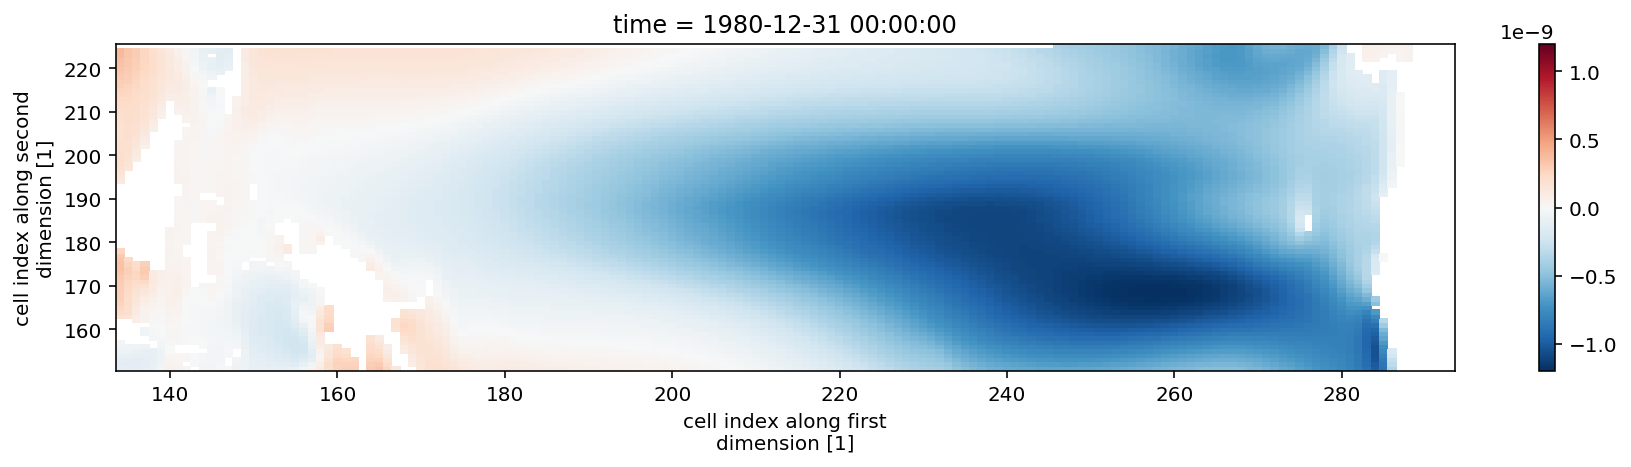

In [15]:
fig, axes = plt.subplots(figsize=(15,3))
mean_70[130].plot()

In [17]:
from IPython import display as disp

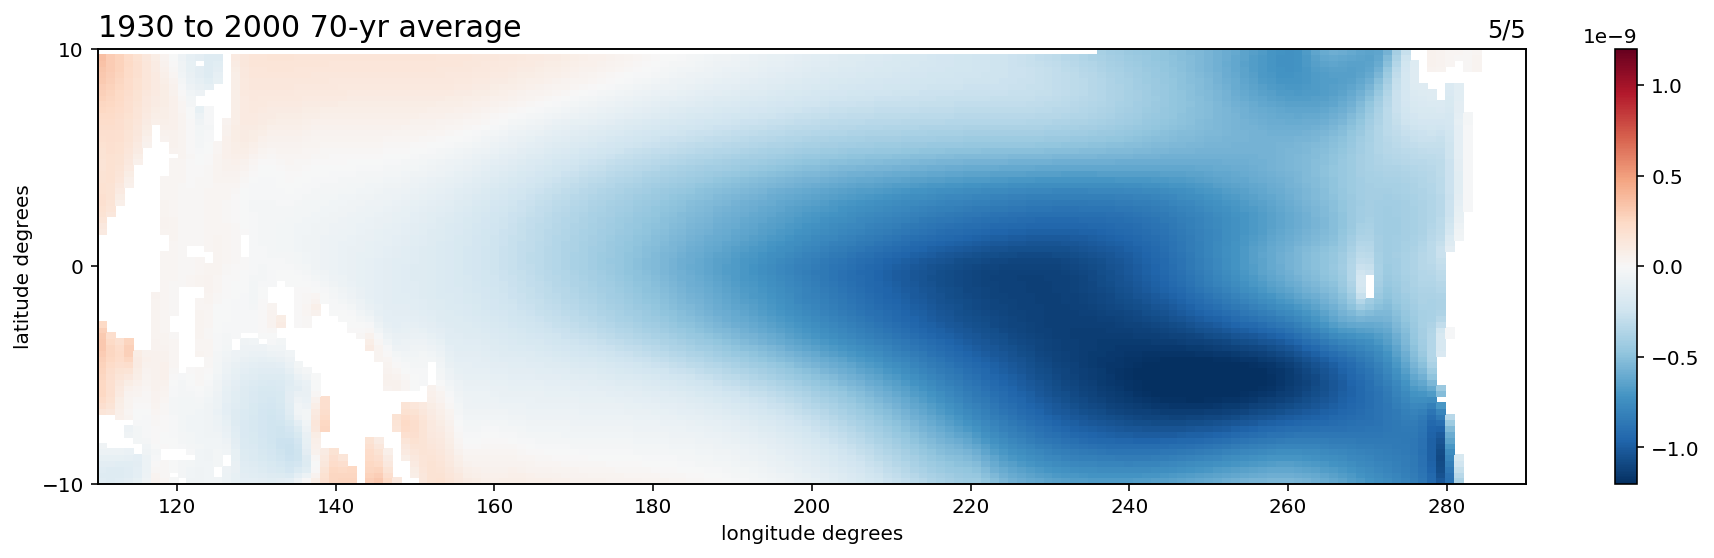

In [19]:
# plot every 20 years

iter=20
window = 70
N = int(window/2)

i=0
for n in np.arange(N,166-N,iter):
    fig, ax = plt.subplots(figsize=(16,4))
    mean_70[n].plot(ax=ax,vmax=1.2e-9,vmin=-1.2e-9,extend='neither',cmap='RdBu_r')
    plt.savefig('CESM2_'+str(window)+'yr_'+str(1850+n)+'.png')
    
    # Customising the axes
    i+=1
    plt.title(str(i)+'/'+str(len(np.arange(N,166-N,iter))), loc='right')
    plt.title('', loc='center')
    plt.xlabel('')
    plt.ylabel('')
    plt.axis('off')
    
    ax2 = ax.twinx()
    ax2.set_ylim([-10,10])
    ax2.set_yticks([-10,0,10])
    ax2.set_ylabel('latitude degrees')
    ax2.yaxis.tick_left()
    ax2.yaxis.set_label_position("left")

    ax3 = ax.twiny()
    ax3.set_xlim([110,290])
    ax3.set_xlabel('longitude degrees')
    ax3.xaxis.tick_bottom()
    ax3.xaxis.set_label_position("bottom")
    
    ax.set_title(str(1850-N+n)+' to '+str(1850+N+n)+' '+str(window)+'-yr average',loc='left',size=15)
    
    disp.clear_output(wait=True)
    plt.show(block=False)
    time.sleep(0.05)
    ax.clear()
   

### 50 yr rolling windows

In [20]:
mean_50 = da_yearly.chunk({'time':-1}).rolling(time=50,center=True).mean().load()
mean_50 = mean_50.mean(dim='member')

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


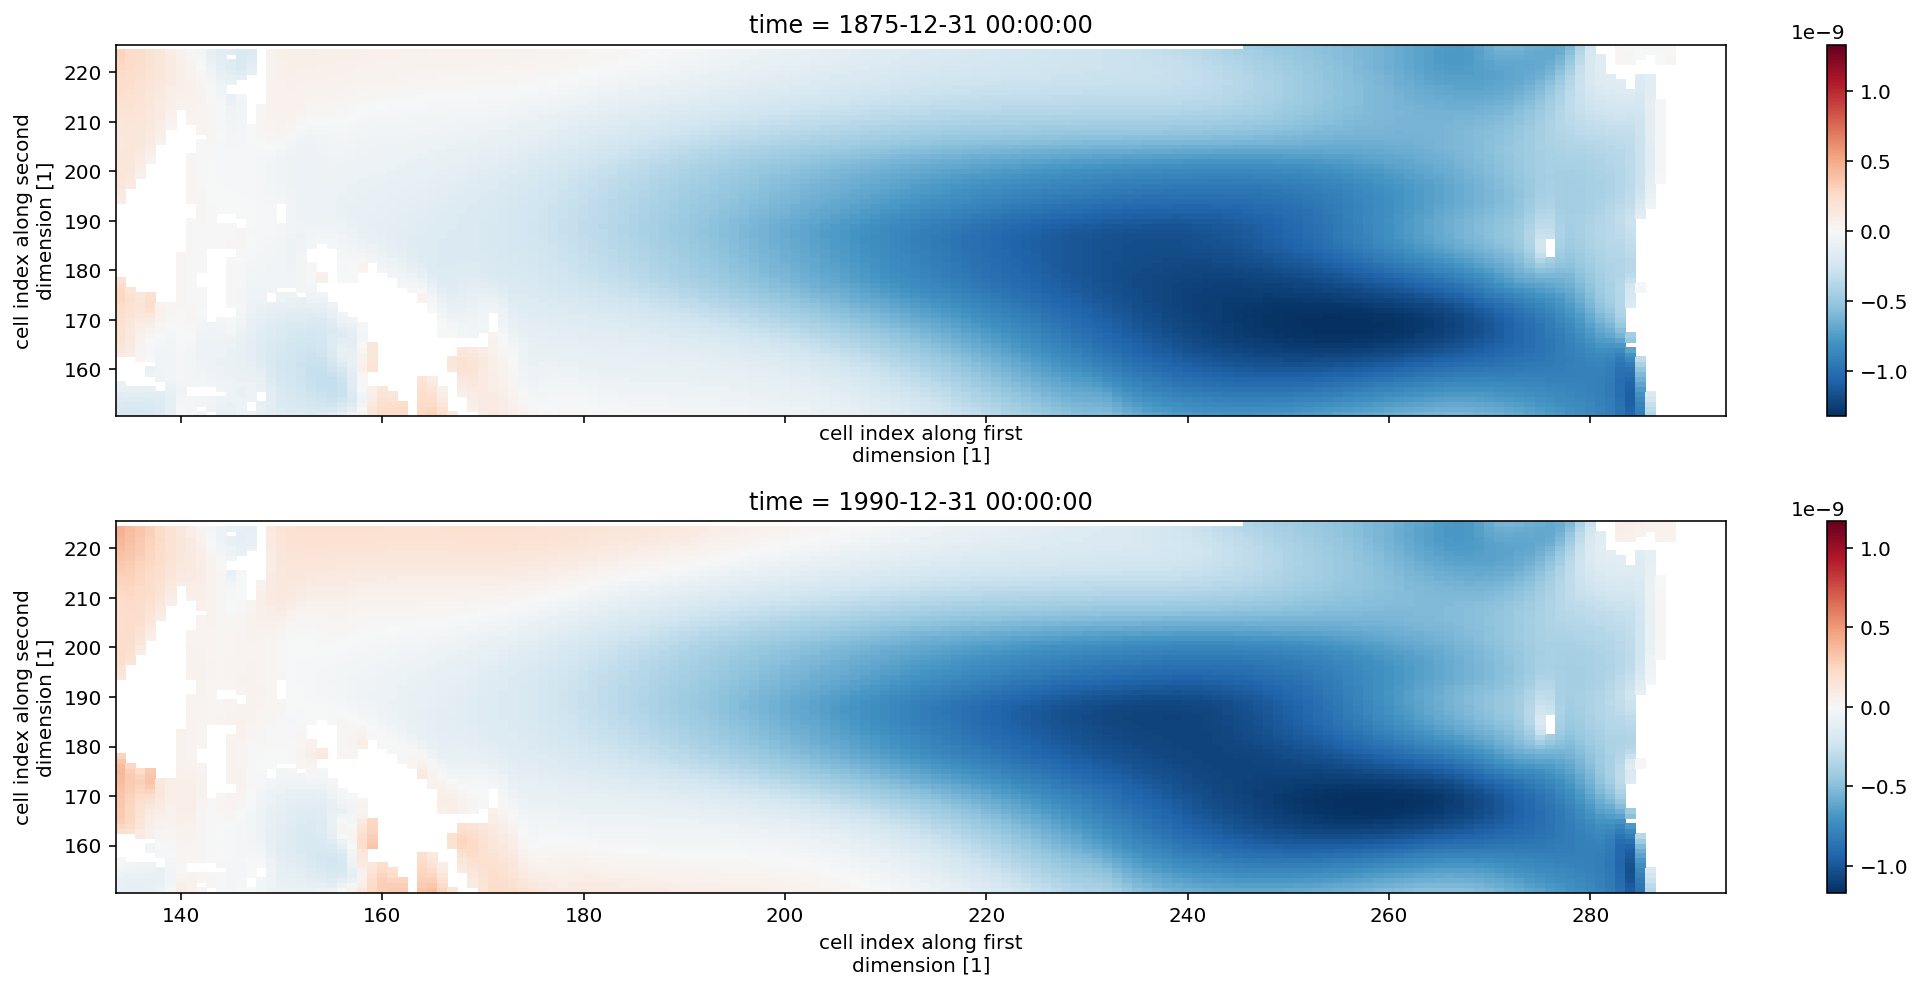

In [24]:
window = 50
N = int(window/2)

fig , axes = plt.subplots(figsize=(15,7),nrows=2,ncols=1,sharex=True)
mean_50[N].plot(ax=axes[0])
mean_50[165-N].plot(ax=axes[1])
plt.tight_layout()

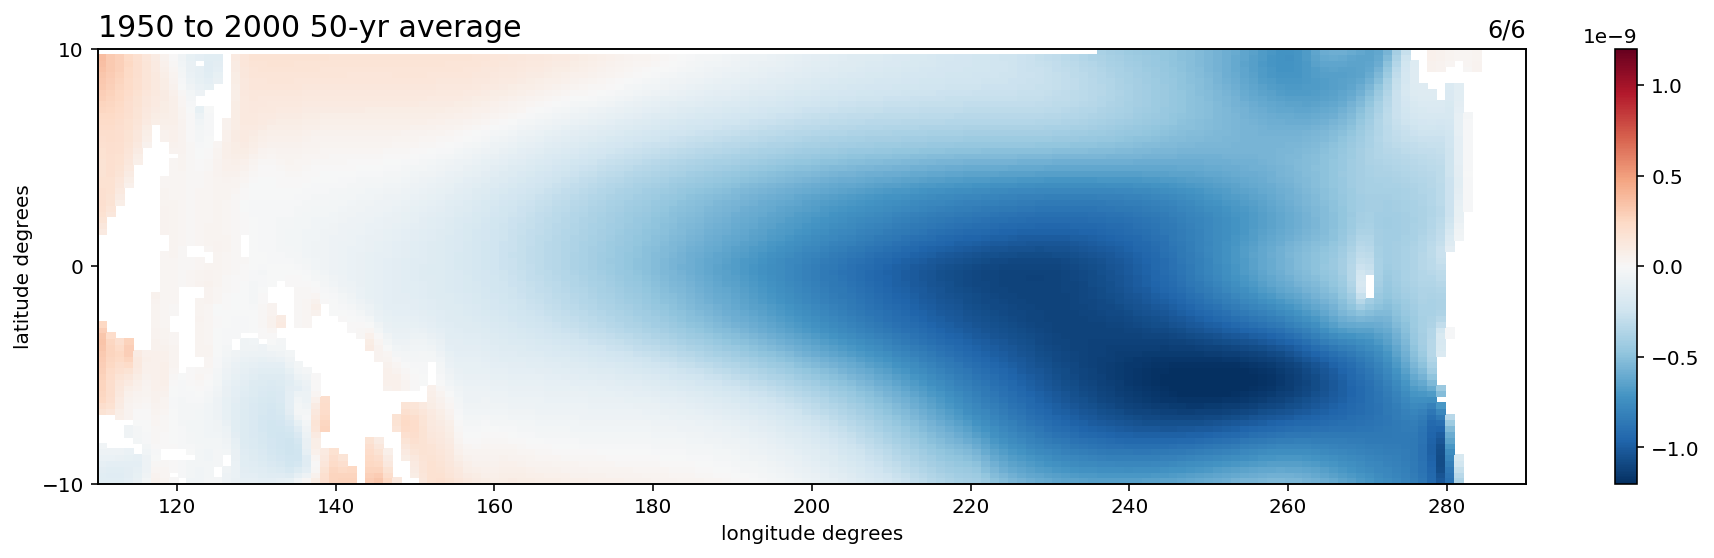

In [27]:
# plot every 20 years

iter=20
window = 50
N = int(window/2)

i=0
for n in np.arange(N,166-N,iter):
    fig, ax = plt.subplots(figsize=(16,4))
    mean_50[n].plot(ax=ax,vmax=1.2e-9,vmin=-1.2e-9,extend='neither',cmap='RdBu_r')
    plt.savefig('CESM2_'+str(window)+'yr_'+str(1850+n)+'.png')
    
    # Customising the axes
    i+=1
    plt.title(str(i)+'/'+str(len(np.arange(N,166-N,iter))), loc='right')
    plt.title('', loc='center')
    plt.xlabel('')
    plt.ylabel('')
    plt.axis('off')
    
    ax2 = ax.twinx()
    ax2.set_ylim([-10,10])
    ax2.set_yticks([-10,0,10])
    ax2.set_ylabel('latitude degrees')
    ax2.yaxis.tick_left()
    ax2.yaxis.set_label_position("left")

    ax3 = ax.twiny()
    ax3.set_xlim([110,290])
    ax3.set_xlabel('longitude degrees')
    ax3.xaxis.tick_bottom()
    ax3.xaxis.set_label_position("bottom")
    
    ax.set_title(str(1850-N+n)+' to '+str(1850+N+n)+' '+str(window)+'-yr average',loc='left',size=15)
    
    disp.clear_output(wait=True)
    plt.show(block=False)
    time.sleep(0.05)
    ax.clear()
   

### 30 yr rolling windows

In [28]:
mean_30 = da_yearly.chunk({'time':-1}).rolling(time=30,center=True).mean().load()
mean_30 = mean_30.mean(dim='member')

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


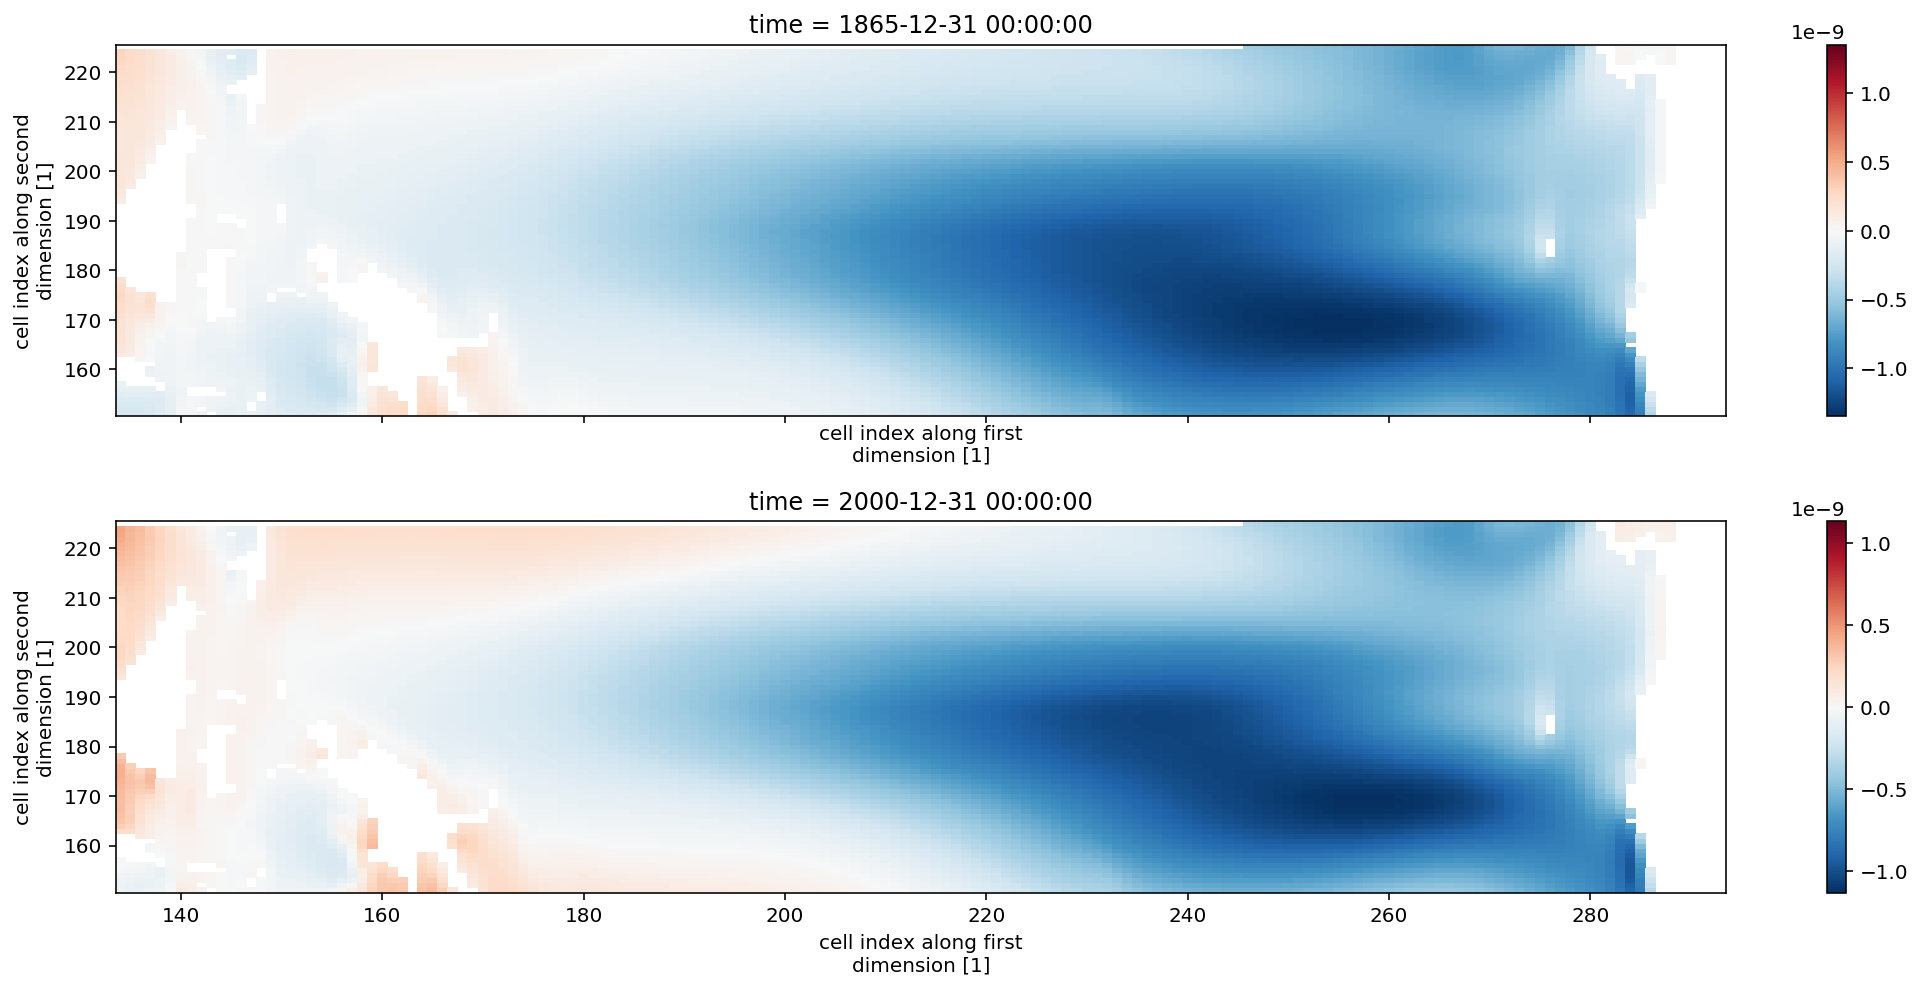

In [30]:
window = 30
N = int(window/2)

fig , axes = plt.subplots(figsize=(15,7),nrows=2,ncols=1,sharex=True)
mean_30[N].plot(ax=axes[0])
mean_30[165-N].plot(ax=axes[1])
plt.tight_layout()

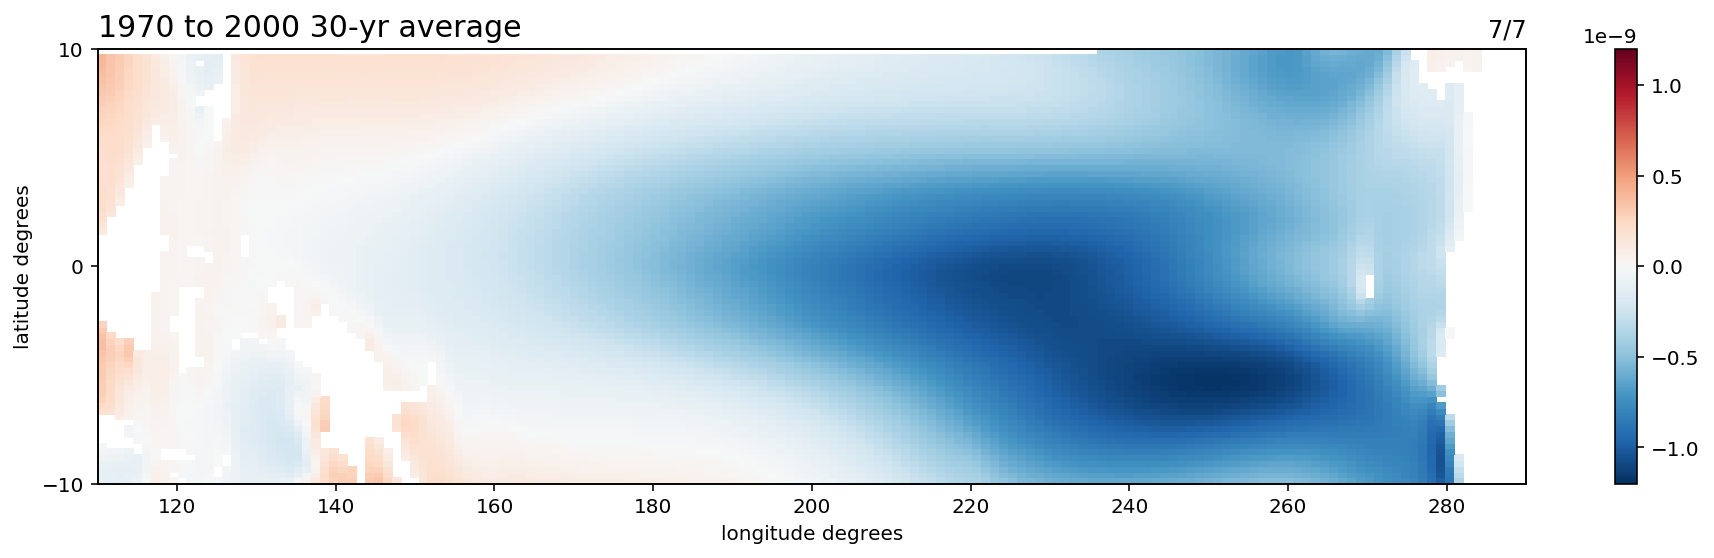

In [31]:
# plot every 20 years

iter=20
window = 30
N = int(window/2)

i=0
for n in np.arange(N,166-N,iter):
    fig, ax = plt.subplots(figsize=(16,4))
    mean_30[n].plot(ax=ax,vmax=1.2e-9,vmin=-1.2e-9,extend='neither',cmap='RdBu_r')
    plt.savefig('CESM2_'+str(window)+'yr_'+str(1850+n)+'.png')
    
    # Customising the axes
    i+=1
    plt.title(str(i)+'/'+str(len(np.arange(N,166-N,iter))), loc='right')
    plt.title('', loc='center')
    plt.xlabel('')
    plt.ylabel('')
    plt.axis('off')
    
    ax2 = ax.twinx()
    ax2.set_ylim([-10,10])
    ax2.set_yticks([-10,0,10])
    ax2.set_ylabel('latitude degrees')
    ax2.yaxis.tick_left()
    ax2.yaxis.set_label_position("left")

    ax3 = ax.twiny()
    ax3.set_xlim([110,290])
    ax3.set_xlabel('longitude degrees')
    ax3.xaxis.tick_bottom()
    ax3.xaxis.set_label_position("bottom")
    
    ax.set_title(str(1850-N+n)+' to '+str(1850+N+n)+' '+str(window)+'-yr average',loc='left',size=15)
    
    disp.clear_output(wait=True)
    plt.show(block=False)
    time.sleep(0.05)
    ax.clear()
   

### 10 yr rolling windows

In [32]:
mean_10 = da_yearly.chunk({'time':-1}).rolling(time=10,center=True).mean().load()
mean_10 = mean_10.mean(dim='member')

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


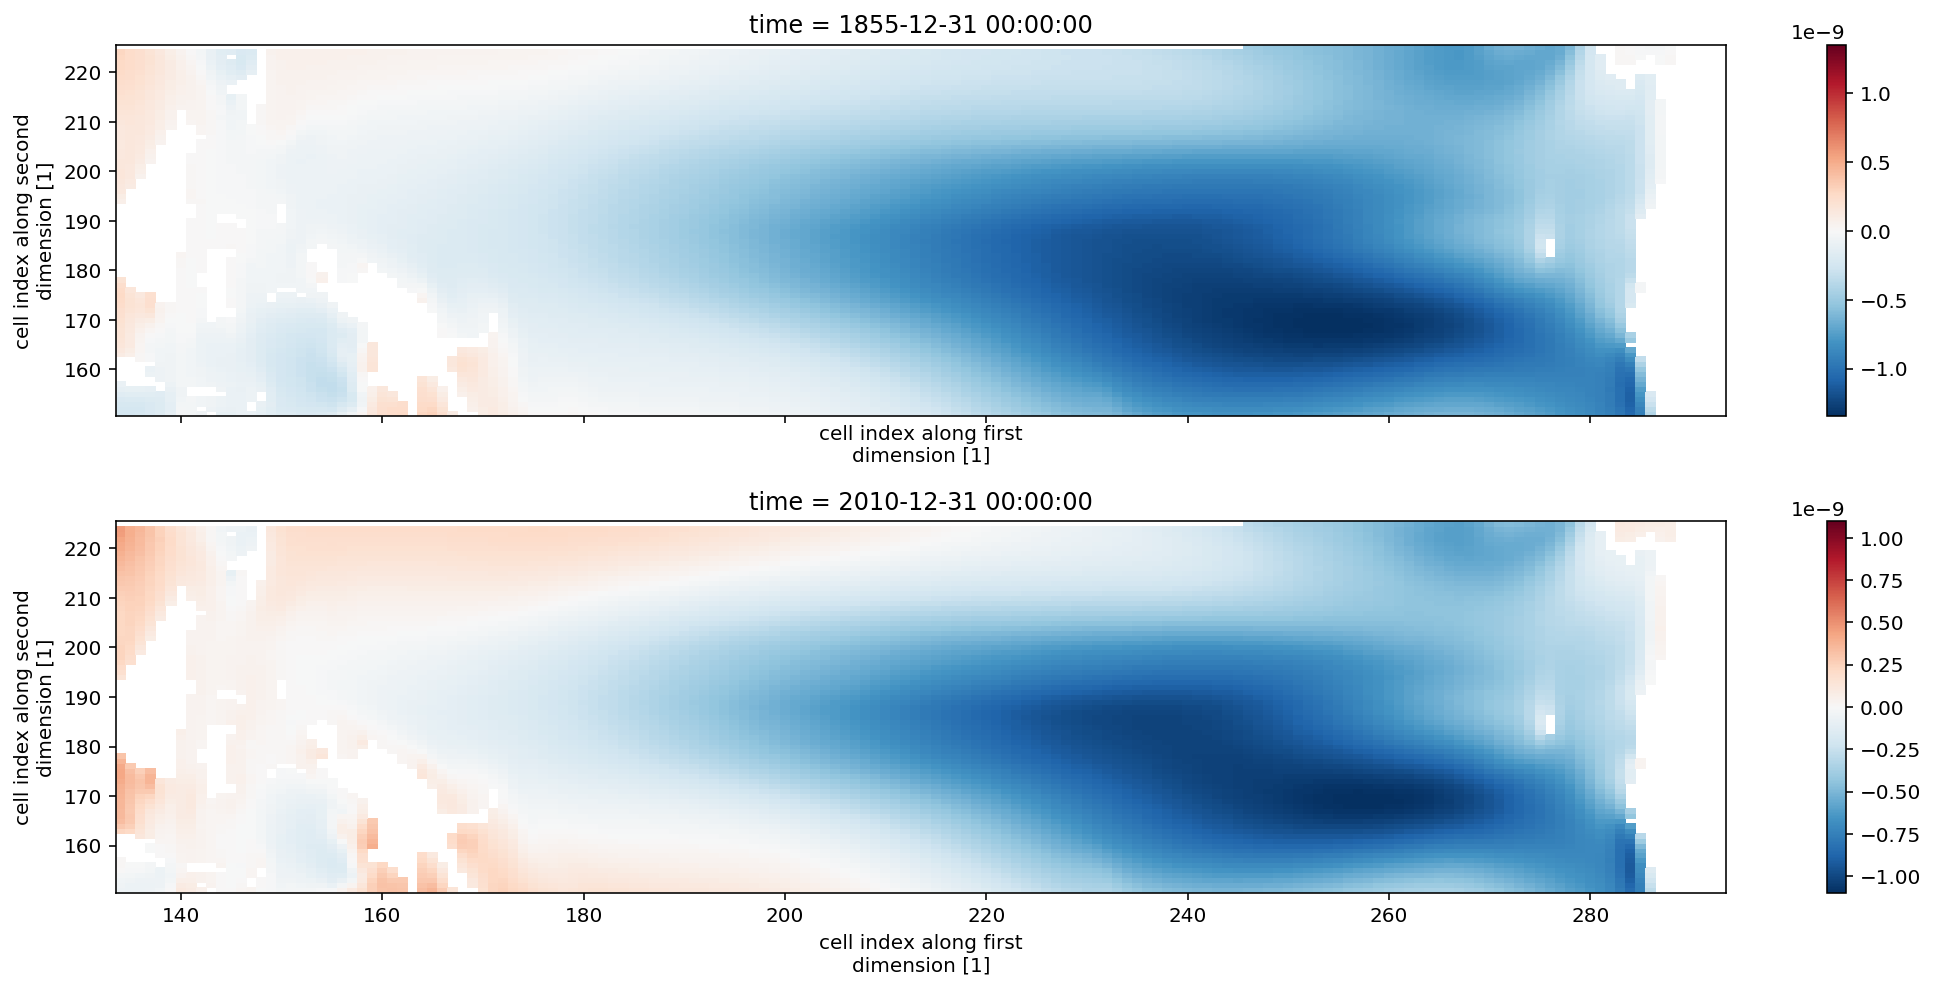

In [33]:
window = 10
N = int(window/2)

fig , axes = plt.subplots(figsize=(15,7),nrows=2,ncols=1,sharex=True)
mean_10[N].plot(ax=axes[0])
mean_10[165-N].plot(ax=axes[1])
plt.tight_layout()

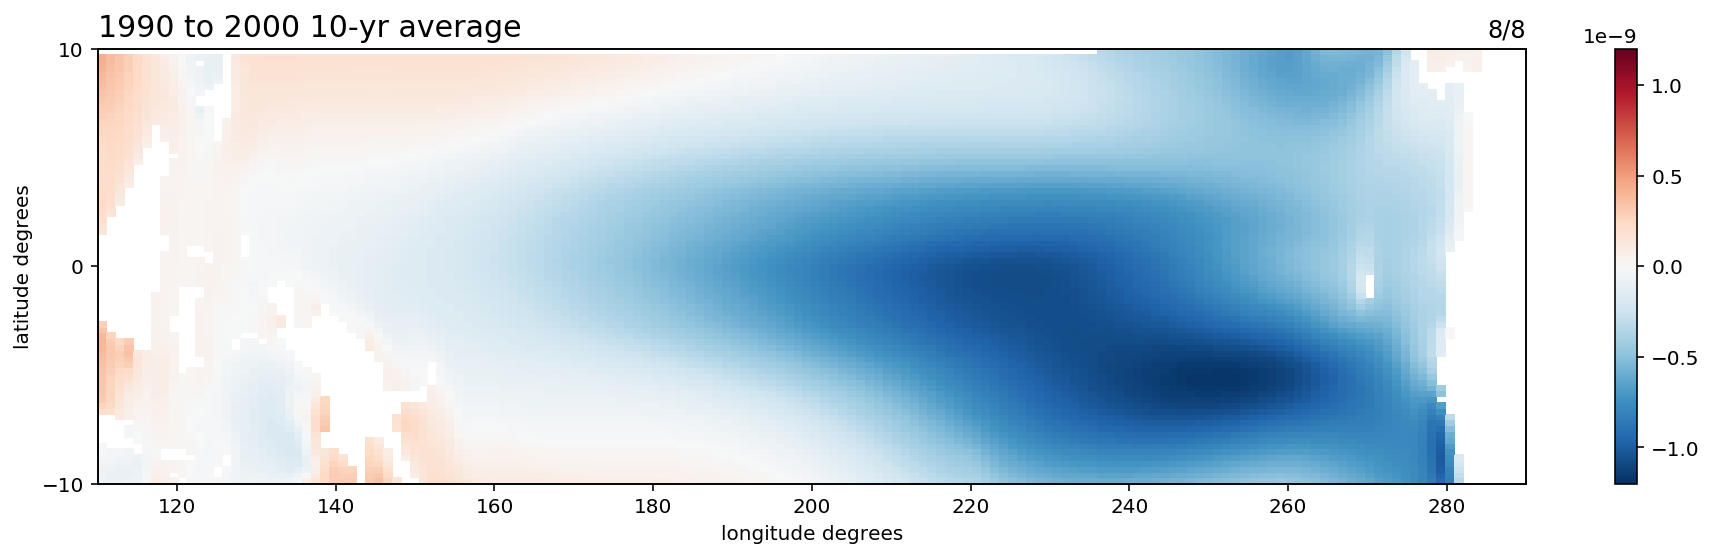

In [34]:
# plot every 20 years

iter=20
window = 10
N = int(window/2)

i=0
for n in np.arange(N,166-N,iter):
    fig, ax = plt.subplots(figsize=(16,4))
    mean_10[n].plot(ax=ax,vmax=1.2e-9,vmin=-1.2e-9,extend='neither',cmap='RdBu_r')
    plt.savefig('CESM2_'+str(window)+'yr_'+str(1850+n)+'.png')
    
    # Customising the axes
    i+=1
    plt.title(str(i)+'/'+str(len(np.arange(N,166-N,iter))), loc='right')
    plt.title('', loc='center')
    plt.xlabel('')
    plt.ylabel('')
    plt.axis('off')
    
    ax2 = ax.twinx()
    ax2.set_ylim([-10,10])
    ax2.set_yticks([-10,0,10])
    ax2.set_ylabel('latitude degrees')
    ax2.yaxis.tick_left()
    ax2.yaxis.set_label_position("left")

    ax3 = ax.twiny()
    ax3.set_xlim([110,290])
    ax3.set_xlabel('longitude degrees')
    ax3.xaxis.tick_bottom()
    ax3.xaxis.set_label_position("bottom")
    
    ax.set_title(str(1850-N+n)+' to '+str(1850+N+n)+' '+str(window)+'-yr average',loc='left',size=15)
    
    disp.clear_output(wait=True)
    plt.show(block=False)
    time.sleep(0.05)
    ax.clear()
   

### Yearly averages

In [35]:
# overlap every 4 months, rather than year

In [48]:
mean_1 = da_yearly.chunk({'time':-1}).rolling(time=1,center=True).mean().load()
mean_1 = mean_1.mean(dim='member')

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


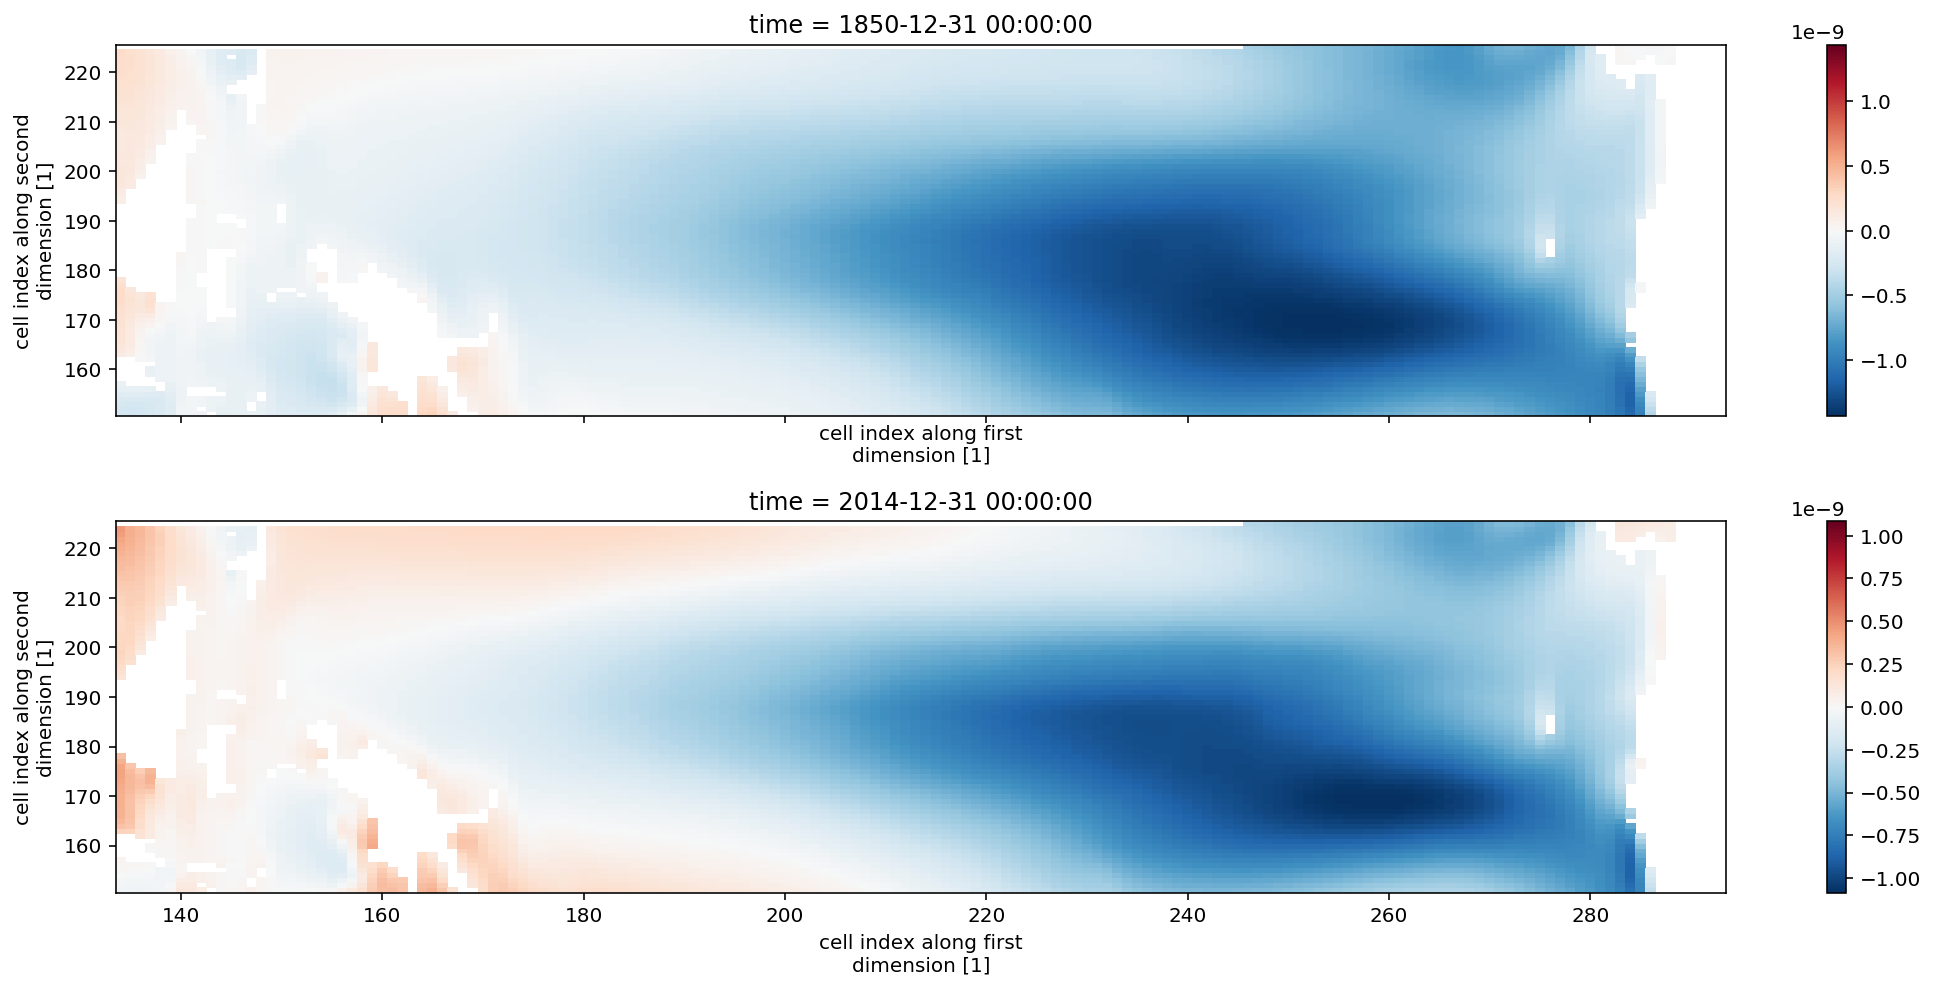

In [51]:
window = 1

fig , axes = plt.subplots(figsize=(15,7),nrows=2,ncols=1,sharex=True)
mean_1[0].plot(ax=axes[0])
mean_1[164].plot(ax=axes[1])
plt.tight_layout()

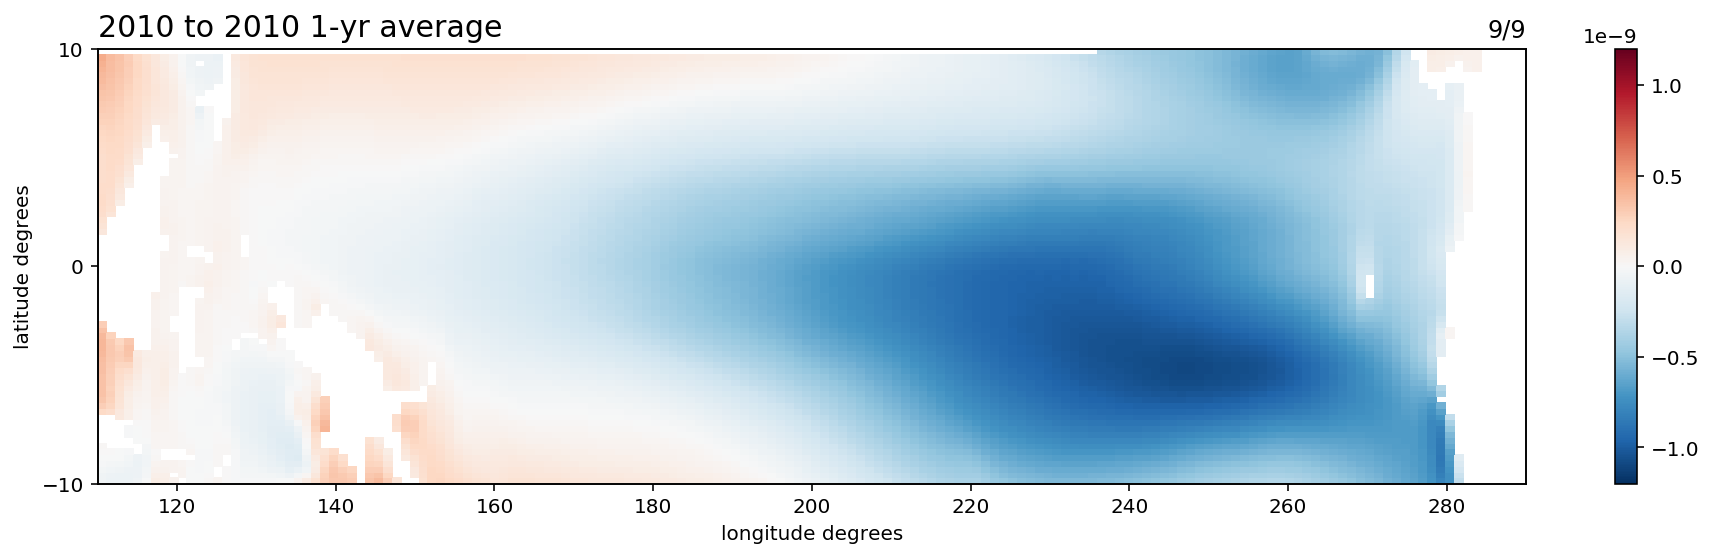

In [56]:
# plot every 20 years

iter=20
window = 1
N = 0
total = len(mean_1) + 1

i=0
for n in np.arange(N,total-N,iter):
    fig, ax = plt.subplots(figsize=(16,4))
    mean_1[n].plot(ax=ax,vmax=1.2e-9,vmin=-1.2e-9,extend='neither',cmap='RdBu_r')
    plt.savefig('CESM2_'+str(window)+'yr_'+str(1850+n)+'.png')
    
    # Customising the axes
    i+=1
    plt.title(str(i)+'/'+str(len(np.arange(N,total-N,iter))), loc='right')
    plt.title('', loc='center')
    plt.xlabel('')
    plt.ylabel('')
    plt.axis('off')
    
    ax2 = ax.twinx()
    ax2.set_ylim([-10,10])
    ax2.set_yticks([-10,0,10])
    ax2.set_ylabel('latitude degrees')
    ax2.yaxis.tick_left()
    ax2.yaxis.set_label_position("left")

    ax3 = ax.twiny()
    ax3.set_xlim([110,290])
    ax3.set_xlabel('longitude degrees')
    ax3.xaxis.tick_bottom()
    ax3.xaxis.set_label_position("bottom")
    
    ax.set_title(str(1850-N+n)+' to '+str(1850+N+n)+' '+str(window)+'-yr average',loc='left',size=15)
    
    disp.clear_output(wait=True)
    plt.show(block=False)
    time.sleep(0.1)
    ax.clear()
   

### 1 year rolling windows, with 4 months overlap

In [58]:
mean_1_4mo_overlap = ds_band.resample(time='4M').mean().chunk({'time':-1}).rolling(time=1,center=True).mean().load()
mean_1_4mo_overlap = mean_1_4mo_overlap.mean(dim='member')

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/resample.py:176: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  super().__init__(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


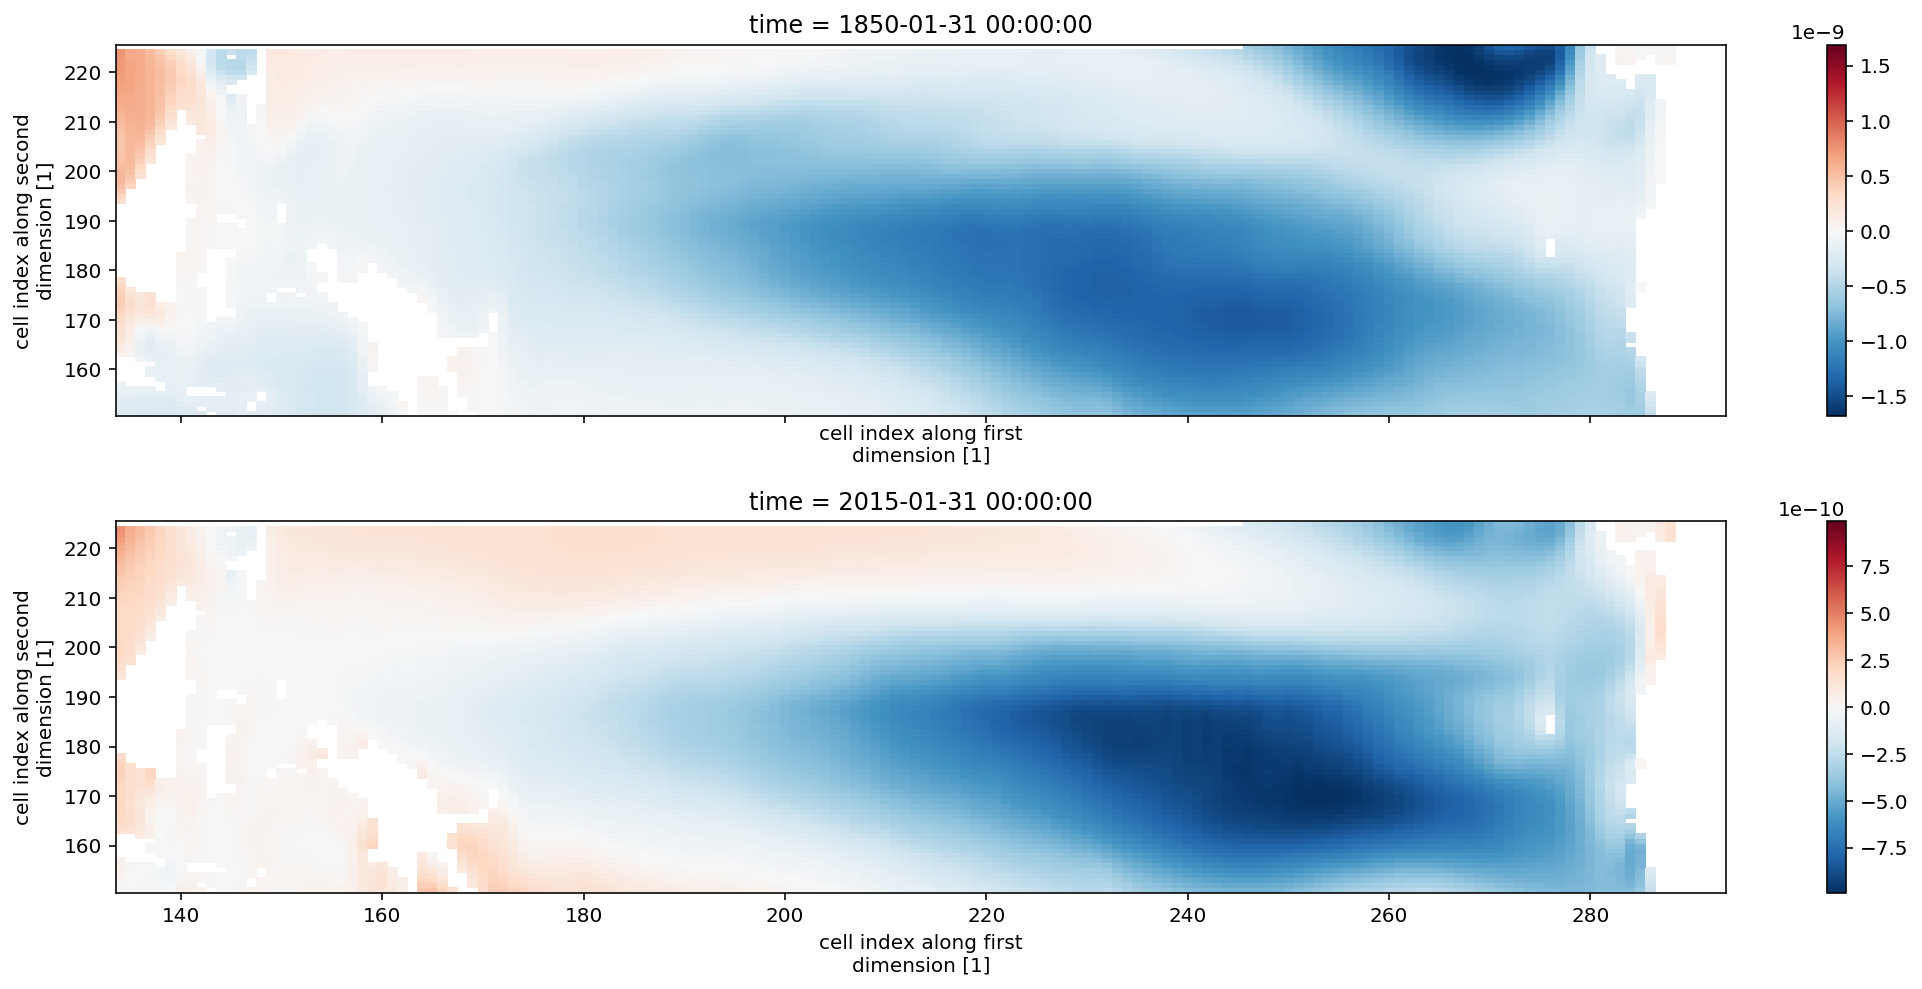

In [71]:
window = 1

fig , axes = plt.subplots(figsize=(15,7),nrows=2,ncols=1,sharex=True)
mean_1_4mo_overlap[0].plot(ax=axes[0])
mean_1_4mo_overlap[495].plot(ax=axes[1])
plt.tight_layout()

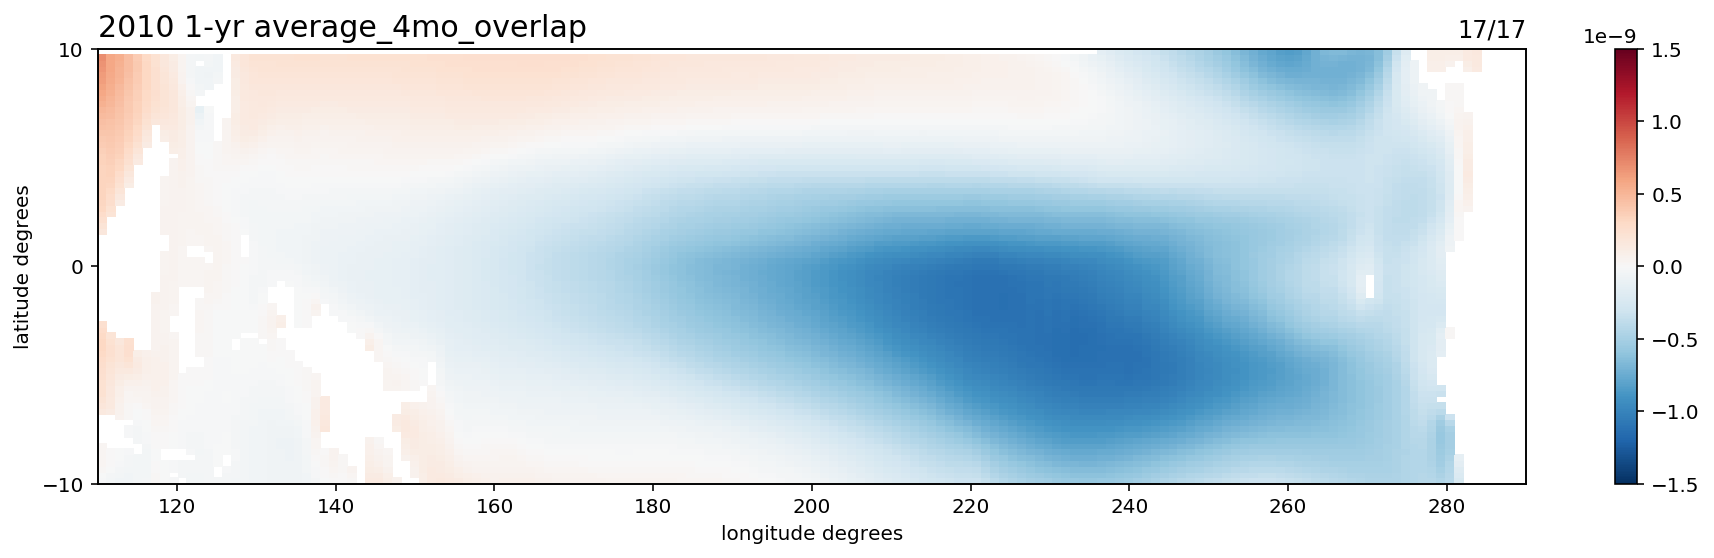

In [104]:
# plot every 10 years i.e. 30 4-month periods

iter=30
window = 1
N = 0
total = len(mean_1_4mo_overlap)

i=0
for n in np.arange(N,total,iter):
    fig, ax = plt.subplots(figsize=(16,4))
    mean_1_4mo_overlap[n].plot(ax=ax,vmax=1.5e-9,vmin=-1.5e-9,extend='neither',cmap='RdBu_r')
    plt.savefig('CESM2_'+str(window)+'yr_overlapping_'+str(1850+int(4*n/12))+'.png')
    
    # Customising the axes
    i+=1
    plt.title(str(i)+'/'+str(len(np.arange(N,total-N,iter))), loc='right')
    plt.title('', loc='center')
    plt.xlabel('')
    plt.ylabel('')
    plt.axis('off')
    
    ax2 = ax.twinx()
    ax2.set_ylim([-10,10])
    ax2.set_yticks([-10,0,10])
    ax2.set_ylabel('latitude degrees')
    ax2.yaxis.tick_left()
    ax2.yaxis.set_label_position("left")

    ax3 = ax.twiny()
    ax3.set_xlim([110,290])
    ax3.set_xlabel('longitude degrees')
    ax3.xaxis.tick_bottom()
    ax3.xaxis.set_label_position("bottom")
    
    ax.set_title(str(1850+int(4*n/12))+' '+str(window)+'-yr average_4mo_overlap',loc='left',size=15)
    
    disp.clear_output(wait=True)
    plt.show(block=False)
    time.sleep(0.2)
    ax.clear()
   